<a href="https://colab.research.google.com/github/ngochif/fngochi_64061/blob/main/Car_Reviews_Project_(Text_Analytics).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Importing Libraries**

In [14]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from gensim.models import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob  # For sentiment analysis
from gensim.models.ldamodel import LdaModel #For Topic Modeling

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM

# Model Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**2. Data Import and Processing**

In [3]:
#Import dataset
from google.colab import files
import pandas as pd
uploaded = files.upload()

Saving car_reviews_large.csv to car_reviews_large.csv


In [5]:
# Load the dataset
data = pd.read_csv('car_reviews_large.csv')

In [6]:
# Display the initial data
print(data.head())
print("Initial number of rows:", data.shape[0])

   reviewid   make model  year                         title       author  \
0         1  ACURA   ILX  2017                     A new Dud  Laurel Blue   
1         2  ACURA   ILX  2015               Noisy as heck !       Seth L   
2         3  ACURA   ILX  2015  Great entry level luxury car      NicBran   
3         4  ACURA   ILX  2015                  Amazing Car!     robin707   
4         5  ACURA   ILX  2015         My ILX is a great car   stevenrose   

   perform_rating  comfort_rating  fuel_econ_rating  fun_rating  ...  \
0               0               0                 0           0  ...   
1               0               0                 0           0  ...   
2               0               0                 0           0  ...   
3               5               5                 4           5  ...   
4               5               5                 5           5  ...   

   exterior_rating  build_qual_rating  reliab_rating  \
0                0                  0           

In [7]:
# Cleaning null values
data.dropna(inplace=True)
print("Number of rows after dropping nulls:", data.shape[0])

Number of rows after dropping nulls: 80476


In [8]:
# Combine textual data into a single column
data['all_text'] = data['title'].str.cat(data[['text', 'fav_feat', 'sugg_imp']], sep=' ')

In [9]:
#Checking to ensure the all text column is added
print(data.head())

   reviewid   make model  year  \
3         4  ACURA   ILX  2015   
4         5  ACURA   ILX  2015   
6         7  ACURA   ILX  2014   
7         8  ACURA   ILX  2014   
9        10  ACURA   ILX  2014   

                                               title      author  \
3                                       Amazing Car!    robin707   
4                              My ILX is a great car  stevenrose   
6                                            Love it     wdc6446   
7  What you expect from the driver's seat isn't w...     zoomjag   
9         Great Alternative to Boring Commuter Cars!   david_d82   

   perform_rating  comfort_rating  fuel_econ_rating  fun_rating  ...  \
3               5               5                 4           5  ...   
4               5               5                 5           5  ...   
6               5               5                 5           5  ...   
7               2               3                 3           3  ...   
9               4         

**2. Exploratory Data Analysis**

*Descriptive Statistics*

In [10]:
print(data.describe())# Summarize the statistical details for numerical variables

            reviewid          year  perform_rating  comfort_rating  \
count   80476.000000  80476.000000    80476.000000    80476.000000   
mean    55673.121987   2008.936229        4.457229        4.500112   
std     31875.675889      1.937722        0.908062        0.855100   
min         4.000000   2007.000000        0.000000        0.000000   
25%     28293.750000   2007.000000        4.000000        4.000000   
50%     56050.500000   2008.000000        5.000000        5.000000   
75%     83319.250000   2010.000000        5.000000        5.000000   
max    110121.000000   2016.000000        5.000000        5.000000   

       fuel_econ_rating    fun_rating  interior_rating  exterior_rating  \
count      80476.000000  80476.000000     80476.000000     80476.000000   
mean           4.136090      4.503044         4.473284         4.650678   
std            1.035376      0.928726         0.879461         0.715791   
min            0.000000      0.000000         0.000000         0.0000

*Visualization*

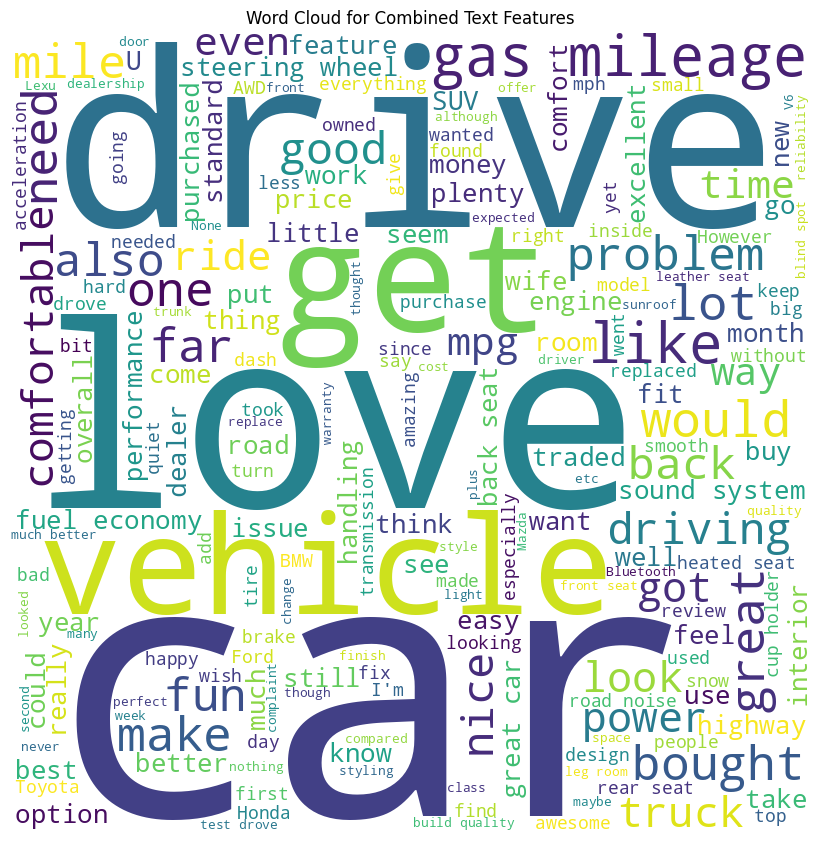

In [21]:
# Word Cloud
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords.words('english'),
                      min_font_size = 10).generate(' '.join(data['all_text']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud for Combined Text Features')
plt.show()

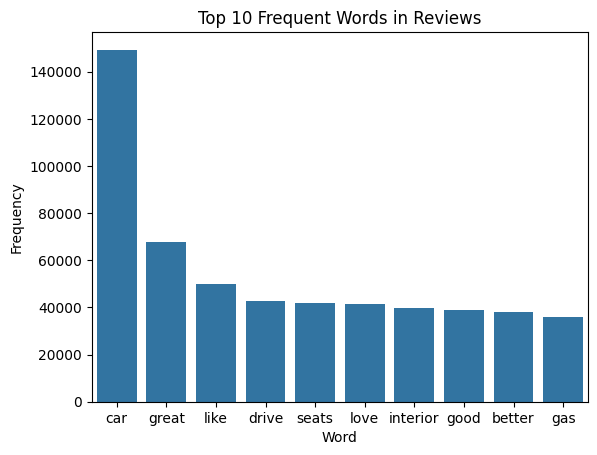

In [16]:
# Top Words
vec = CountVectorizer(stop_words='english')
text_matrix = vec.fit_transform(data['all_text'])
sum_words = text_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
top_words_df = pd.DataFrame(words_freq[:10], columns=['Word', 'Frequency'])
sns.barplot(x='Word', y='Frequency', data=top_words_df)
plt.title('Top 10 Frequent Words in Reviews')
plt.show()

*Sentiment Analysis*

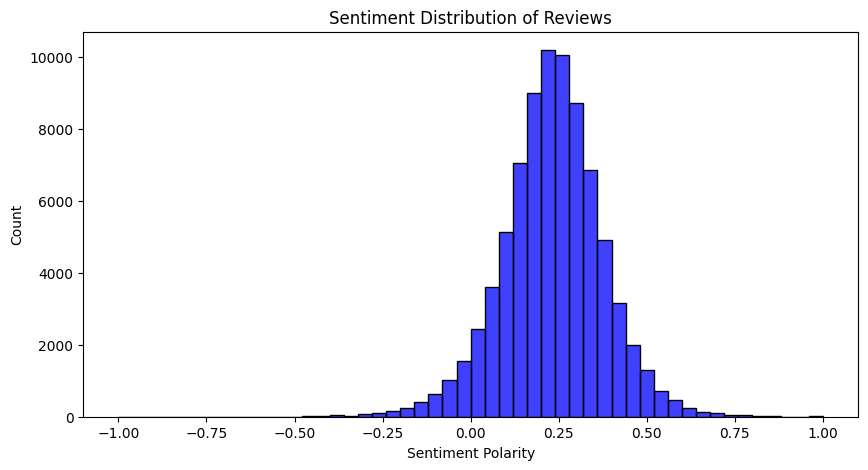

In [17]:
data['sentiment'] = data['all_text'].apply(lambda text: TextBlob(text).sentiment.polarity)
plt.figure(figsize=(10, 5))
sns.histplot(data['sentiment'], bins=50, kde=False, color='blue')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.show()

*Topic Modeling Using LDA*

In [68]:
# Preparing the text data
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
data['tokens'] = data['all_text'].apply(lambda x: [token for token in tokenizer.tokenize(x.lower()) if token not in stop_words])

# Creating a dictionary and corpus
dictionary = corpora.Dictionary(data['tokens'])
corpus = [dictionary.doc2bow(text) for text in data['tokens']]

In [69]:
# Number of topics
num_topics = 10

# Build LDA model
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Print the topics identified by LDA model
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print("Topic: {} \nWords: {}".format(idx, topic))

Topic: 0 
Words: 0.074*"car" + 0.024*"love" + 0.018*"great" + 0.018*"drive" + 0.016*"like"
Topic: 1 
Words: 0.021*"car" + 0.020*"interior" + 0.018*"good" + 0.017*"great" + 0.013*"ride"
Topic: 2 
Words: 0.104*"tires" + 0.068*"snow" + 0.045*"tire" + 0.038*"awd" + 0.033*"winter"
Topic: 3 
Words: 0.022*"truck" + 0.020*"vehicle" + 0.017*"suv" + 0.014*"great" + 0.012*"power"
Topic: 4 
Words: 0.023*"volvo" + 0.022*"system" + 0.012*"car" + 0.011*"bmw" + 0.011*"bluetooth"
Topic: 5 
Words: 0.022*"engine" + 0.019*"speed" + 0.018*"transmission" + 0.016*"car" + 0.015*"manual"
Topic: 6 
Words: 0.051*"mpg" + 0.027*"miles" + 0.026*"mileage" + 0.024*"gas" + 0.019*"highway"
Topic: 7 
Words: 0.022*"seats" + 0.017*"leather" + 0.017*"radio" + 0.014*"lights" + 0.014*"interior"
Topic: 8 
Words: 0.026*"seat" + 0.019*"seats" + 0.018*"back" + 0.018*"rear" + 0.012*"front"
Topic: 9 
Words: 0.023*"car" + 0.013*"miles" + 0.010*"dealer" + 0.009*"problem" + 0.009*"problems"


In [70]:
# Assign topics to documents
data['topic'] = [sorted(lda_model[corpus[i]], key=lambda x: -x[1])[0][0] for i in range(len(data))]

# View the topic distribution for the first few documents
print(data[['all_text', 'topic']].head())

                                            all_text  topic
3  Amazing Car! I just purchased the 2015 ILX 2.4...      0
4  My ILX is a great car I really enjoy owning my...      1
6  Love it The more I drive this car, the more I ...      0
7  What you expect from the driver's seat isn't w...      1
9  Great Alternative to Boring Commuter Cars! I b...      0


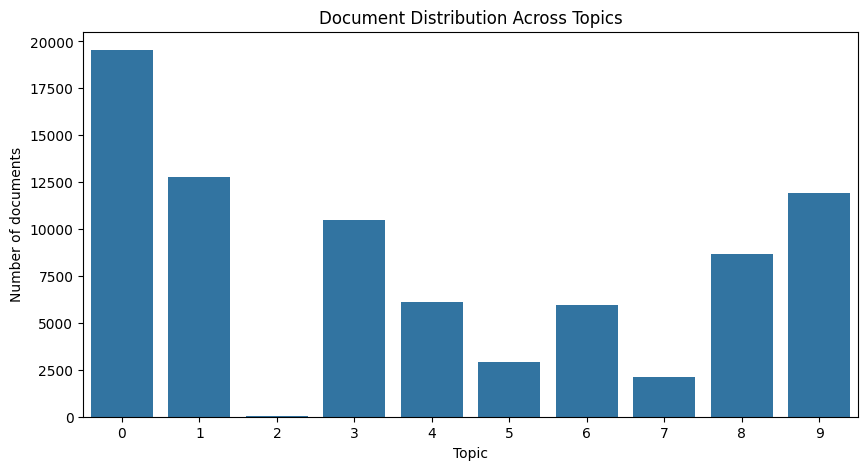

In [71]:
# Count the number of documents in each topic
topic_counts = data['topic'].value_counts()

# Plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.title('Document Distribution Across Topics')
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.show()

**4. Predicting Engagement (Comment Counts) Using Deep Learning**

*Preparing Data*

In [60]:
# Prepare text data for tokenization and padding
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(data['all_text'])
sequences = tokenizer.texts_to_sequences(data['all_text'])
lengths = [len(x) for x in sequences]
maxlen = int(np.percentile(lengths, 80))#Setting the maximum length of sequences to the 80th percentile of sequence lengths
text_data = pad_sequences(sequences, maxlen=maxlen)

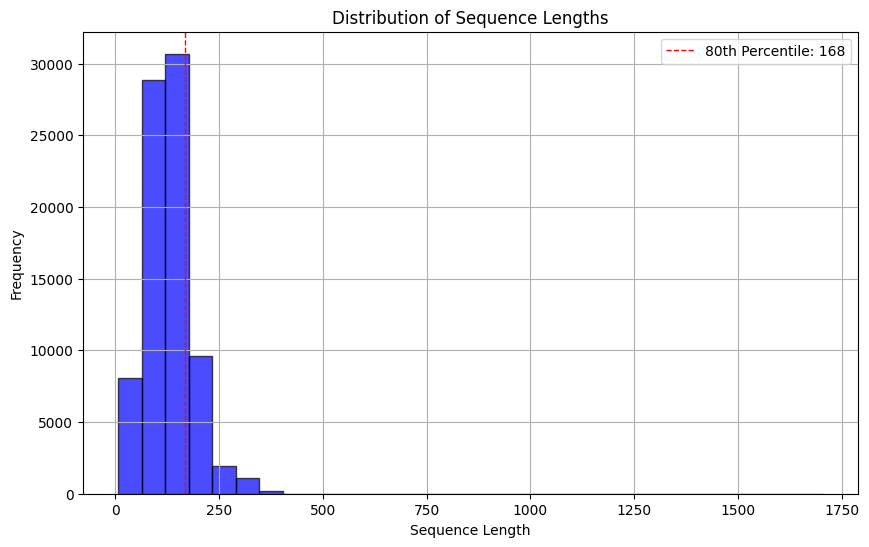

In [59]:
# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(maxlen, color='red', linestyle='dashed', linewidth=1, label=f'80th Percentile: {maxlen}')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Apply TF-IDF to vectorize text data
vectorizer = TfidfVectorizer(max_features=1000)  # Limit number of features to 1000
tfidf_matrix = vectorizer.fit_transform(data['all_text'])

In [23]:
# Prepare numeric features
numeric_features = data[['perform_rating', 'comfort_rating', 'fuel_econ_rating', 'fun_rating', 'interior_rating', 'exterior_rating', 'build_qual_rating', 'reliab_rating']]
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_features)

In [45]:
# Combine text and numeric data for the combined model
combined_input = np.hstack((tfidf_matrix.toarray(), numeric_scaled))

In [25]:
# Target data
target = data['comment_cnt']

In [74]:
# Split the data into train, validation, and test sets (70-20-10)

   #1.Text sequence padded features
X_train_text_temp, X_test_text, y_train_text_temp, y_test_text = train_test_split(
    text_data,
    target,
    test_size=0.1,
    random_state=42
)

X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(
    X_train_text_temp,
    y_train_text_temp,
    test_size=(20/90),  # This is 22.22% of the remaining 90%
    random_state=42
)

   #2.Numeric features
X_train_numeric_temp, X_test_numeric, y_train_numeric_temp, y_test_numeric = train_test_split(
    numeric_scaled,
    target,
    test_size=0.1,
    random_state=42
)
X_train_numeric, X_val_numeric, y_train_numeric, y_val_numeric = train_test_split(
    X_train_numeric_temp,
    y_train_numeric_temp,
    test_size=(20/90),
    random_state=42
)

   #3.Combined features
X_train_combined_temp, X_test_combined, y_train_combined_temp, y_test_combined = train_test_split(
    combined_input,  # Assuming combined_input is the feature set for combined text and numeric data
    target,
    test_size=0.1,
    random_state=42
)
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(
    X_train_combined_temp,
    y_train_combined_temp,
    test_size=(20/90),
    random_state=42
)

   #4. Text sparse TF-IDF representation
X_train_vectorized_temp, X_test_vectorized, y_train_vectorized_temp, y_test_vectorized = train_test_split(
    tfidf_matrix,  # Assuming tfidf_matrix is the feature set for vectorized text data
    target,
    test_size=0.1,
    random_state=42
)
X_train_vectorized, X_val_vectorized, y_train_vectorized, y_val_vectorized = train_test_split(
    X_train_vectorized_temp,
    y_train_vectorized_temp,
    test_size=(20/90),
    random_state=42
)


In [34]:
# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare embedding matrix
embedding_dim = 100  # For 100-dimensional GloVe embeddings
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because index 0 is not used
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Check if the loaded vector has the expected dimension before assigning
        if embedding_vector.shape[0] == embedding_dim:
            embedding_matrix[i] = embedding_vector
        else:
            print(f"Warning: Skipping word '{word}' due to dimension mismatch.")

*Model Training and Evaluation*

a. Comparing numeric features versus combined features predictions

In [79]:
#Model 1: Numeric Data Only (Dense Layers)
model_numeric = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_numeric.shape[1],)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

model_numeric.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = model_numeric.fit(
    X_train_numeric, y_train_numeric,
    validation_data=(X_val_numeric, y_val_numeric),
    epochs=5,
    batch_size=32
)

y_pred_numeric = model_numeric.predict(X_test_numeric)  # Predict on the  test set
mse_numeric = mean_squared_error(y_test_numeric, y_pred_numeric.flatten())
print("MSE for Numeric Data Only Model:", mse_numeric)

Epoch 1/5
1761/1761 [==============================] - 10s 4ms/step - loss: 0.5364 - mean_squared_error: 0.5364 - val_loss: 0.4298 - val_mean_squared_error: 0.4298
Epoch 2/5
1761/1761 [==============================] - 8s 4ms/step - loss: 0.5319 - mean_squared_error: 0.5319 - val_loss: 0.4315 - val_mean_squared_error: 0.4315
Epoch 3/5
1761/1761 [==============================] - 7s 4ms/step - loss: 0.5309 - mean_squared_error: 0.5309 - val_loss: 0.4300 - val_mean_squared_error: 0.4300
Epoch 4/5
1761/1761 [==============================] - 9s 5ms/step - loss: 0.5295 - mean_squared_error: 0.5295 - val_loss: 0.4303 - val_mean_squared_error: 0.4303
Epoch 5/5
252/252 [==============================] - 1s 3ms/step
MSE for Numeric Data Only Model: 0.17728228520495903


In [81]:
#Model 2: Combining Text and Numeric Data
model_combined = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_combined.shape[1],)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

model_combined.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history_combined = model_combined.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val_combined, y_val_combined),
    epochs=5,
    batch_size=32
)

y_pred_combined = model_combined.predict(X_test_combined)  # Predict on the  test set
mse_combined = mean_squared_error(y_test_combined, y_pred_combined.flatten())
print("MSE for Combined Model:", mse_combined)

Epoch 1/5
1761/1761 [==============================] - 17s 9ms/step - loss: 0.5275 - mean_squared_error: 0.5275 - val_loss: 0.4226 - val_mean_squared_error: 0.4226
Epoch 2/5
1761/1761 [==============================] - 16s 9ms/step - loss: 0.4691 - mean_squared_error: 0.4691 - val_loss: 0.4143 - val_mean_squared_error: 0.4143
Epoch 3/5
1761/1761 [==============================] - 16s 9ms/step - loss: 0.3363 - mean_squared_error: 0.3363 - val_loss: 0.3983 - val_mean_squared_error: 0.3983
Epoch 4/5
1761/1761 [==============================] - 16s 9ms/step - loss: 0.2758 - mean_squared_error: 0.2758 - val_loss: 0.3839 - val_mean_squared_error: 0.3839
Epoch 5/5
252/252 [==============================] - 1s 3ms/step
MSE for Combined Model: 0.18148827532957498


In [94]:
#Summary of Model Performances
model_performance = pd.DataFrame({
    "Model": ["Numeric Only",  "Combined Text and Numeric"],
    "MSE": [mse_numeric,  mse_combined]
})
print(model_performance)

                       Model       MSE
0               Numeric Only  0.177282
1  Combined Text and Numeric  0.181488


b. Comparing different approaches for predicting with text only

In [82]:
#Model 3: Text Data with Sparse TF-IDF representation
model_vectorized = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_vectorized.shape[1],)),  # Ensure the input shape matches the number of features in TF-IDF
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

model_vectorized.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history_vectorized = model_vectorized.fit(
    X_train_vectorized.toarray(), y_train_vectorized,
    validation_data=(X_val_vectorized.toarray(), y_val_vectorized),
    epochs=5,
    batch_size=32
)

y_pred_vectorized = model_vectorized.predict(X_test_vectorized.toarray()) # Evaluate the model on the test data
mse_vectorized = mean_squared_error(y_test_vectorized, y_pred_vectorized.flatten())

Epoch 1/5
1761/1761 [==============================] - 18s 9ms/step - loss: 0.5225 - mean_squared_error: 0.5225 - val_loss: 0.4322 - val_mean_squared_error: 0.4322
Epoch 2/5
1761/1761 [==============================] - 14s 8ms/step - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4206 - val_mean_squared_error: 0.4206
Epoch 3/5
1761/1761 [==============================] - 15s 9ms/step - loss: 0.3057 - mean_squared_error: 0.3057 - val_loss: 0.3979 - val_mean_squared_error: 0.3979
Epoch 4/5
1761/1761 [==============================] - 16s 9ms/step - loss: 0.2271 - mean_squared_error: 0.2271 - val_loss: 0.3844 - val_mean_squared_error: 0.3844
Epoch 5/5
252/252 [==============================] - 1s 2ms/step
MSE for Vectorized Model: 0.187880691118302


In [95]:
print("MSE for Text Model with TF-IDF:", mse_vectorized)

MSE for Text Model with TF-IDF: 0.187880691118302


In [83]:
#Model 4: Text Data Only with directly-learned word embeddings
model_text = Sequential([
    Embedding(1000, 64, input_length=maxlen),
    Flatten(),  # Flatten the output of the embedding to pass it to dense layers
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

model_text.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history_text = model_text.fit(
    X_train_text, y_train_text,
    validation_data=(X_val_text, y_val_text),
    epochs=5,
    batch_size=32
)


y_pred_text = model_text.predict(X_test_text)  # Predict on the  test set
mse_text = mean_squared_error(y_test_text, y_pred_text.flatten())

Epoch 1/5
1761/1761 [==============================] - 116s 63ms/step - loss: 0.4676 - mean_squared_error: 0.4676 - val_loss: 0.4113 - val_mean_squared_error: 0.4113
Epoch 2/5
1761/1761 [==============================] - 122s 69ms/step - loss: 0.4508 - mean_squared_error: 0.4508 - val_loss: 0.4044 - val_mean_squared_error: 0.4044
Epoch 3/5
1761/1761 [==============================] - 118s 67ms/step - loss: 0.1657 - mean_squared_error: 0.1657 - val_loss: 0.3711 - val_mean_squared_error: 0.3711
Epoch 4/5
1761/1761 [==============================] - 117s 67ms/step - loss: 0.1697 - mean_squared_error: 0.1697 - val_loss: 0.3806 - val_mean_squared_error: 0.3806
Epoch 5/5
252/252 [==============================] - 2s 9ms/step
MSE for Text Data Only with Dense Layers: 0.17556880121050952


In [96]:
print("MSE for Text Data with Learned Embeddings:", mse_text)

MSE for Text Data with Learned Embeddings: 0.17556880121050952


In [84]:
#Model 5: Text Data Only with LSTM and learned embeddings
model_lstm = Sequential([
    Embedding(1000, 64, input_length=maxlen),
    LSTM(64),  # LSTM layer with 64 units
    Dense(1, activation='linear')  # Output layer with linear activation for regression
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using the padded sequence data
history_lstm = model_lstm.fit(
    X_train_text, y_train_text,
    validation_data=(X_val_text, y_val_text),
    epochs=5,
    batch_size=32
)

# Evaluate the model on the test data
y_pred_lstm = model_lstm.predict(X_test_text)
mse_lstm = mean_squared_error(y_test_text, y_pred_lstm.flatten())
print("MSE for LSTM Model:", mse_lstm)

Epoch 1/5
1761/1761 [==============================] - 255s 143ms/step - loss: 0.5244 - val_loss: 0.4235
Epoch 2/5
1761/1761 [==============================] - 243s 138ms/step - loss: 0.5029 - val_loss: 0.4186
Epoch 3/5
1761/1761 [==============================] - 228s 130ms/step - loss: 0.4605 - val_loss: 0.4199
Epoch 4/5
1761/1761 [==============================] - 253s 144ms/step - loss: 0.3980 - val_loss: 0.3992
Epoch 5/5
252/252 [==============================] - 15s 57ms/step
MSE for LSTM Model: 0.2070144905639519


In [97]:
print("MSE for LSTM Model with learned embeddings:", mse_lstm)

MSE for LSTM Model with learned embeddings: 0.2070144905639519


In [85]:
#Model 6: Text only with Dense Layer and pretrained GloVe Embeddings
model_text = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model with mean squared error as the loss function
model_text.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using the padded text data
history_text = model_text.fit(
    X_train_text, y_train_text,
    validation_data=(X_val_text, y_val_text),
    epochs=5,
    batch_size=32
)

y_pred_text = model_text.predict(X_test_text)  # Predict using the  test data
mse_text_Glove = mean_squared_error(y_test_text, y_pred_text.flatten())

Epoch 1/5
1761/1761 [==============================] - 121s 68ms/step - loss: 0.6653 - val_loss: 0.4366
Epoch 2/5
1761/1761 [==============================] - 122s 70ms/step - loss: 0.4856 - val_loss: 0.4173
Epoch 3/5
1761/1761 [==============================] - 139s 79ms/step - loss: 0.4294 - val_loss: 0.3930
Epoch 4/5
1761/1761 [==============================] - 154s 87ms/step - loss: 0.3908 - val_loss: 0.4029
Epoch 5/5
252/252 [==============================] - 4s 17ms/step
MSE for Text Dense Model with Glove pretrained embedding: 0.18310567392227012


In [98]:
print("MSE for Text  Model with Glove pretrained embedding:", mse_text_Glove)

MSE for Text  Model with Glove pretrained embedding: 0.18310567392227012


In [99]:
#Summary of Textbased Model Performances
model_performance = pd.DataFrame({
    "Model": ["Text Only with learned embeddings", "Text Only with pretrained embeddings", "Text only with TF-IDF", "Text Only with LSTM"],
    "MSE": [mse_text, mse_text_Glove, mse_vectorized, mse_lstm]
})
print(model_performance)

                                  Model       MSE
0     Text Only with learned embeddings  0.175569
1  Text Only with pretrained embeddings  0.183106
2                 Text only with TF-IDF  0.187881
3                   Text Only with LSTM  0.207014
